In [ ]:
!pip install pydicom rdflib networkx matplotlib

In [2]:
import pydicom
from pathlib import Path
from rdflib import Graph, Literal, RDF, URIRef, Namespace
import uuid

In [3]:
# Set directory with DICOM files
dicom_dir = Path("dicom_files")

In [4]:
# Define namespaces
EX = Namespace("http://example.org/ro/")
DCAT = Namespace("http://www.w3.org/ns/dcat#")
DCT = Namespace("http://purl.org/dc/terms/")
FOAF = Namespace("http://xmlns.com/foaf/0.1/")

In [5]:
# Create the RDF Graph
g = Graph()
g.bind("ex", EX)
g.bind("dcat", DCAT)
g.bind("dct", DCT)
g.bind("foaf", FOAF)

In [6]:
# Iterate through all .dcm files in the folder
for dicom_file in dicom_dir.glob("*.dcm"):
    ds = pydicom.dcmread(dicom_file)

    # Extract metadata safely
    metadata = {
        "PatientName": str(ds.get("PatientName", "Unknown")),
        "PatientID": str(ds.get("PatientID", "Unknown")),
        "Modality": str(ds.get("Modality", "Unknown")),
        "StudyDate": str(ds.get("StudyDate", "Unknown")),
        "SeriesDescription": str(ds.get("SeriesDescription", "Unknown")),
        "InstitutionName": str(ds.get("InstitutionName", "Unknown")),
    }

    # Generate a unique URI for each dataset
    dataset_uri = EX[f"dicom_{uuid.uuid4().hex}"]
    g.add((dataset_uri, RDF.type, DCAT.Dataset))

    # Add RDF triples
    g.add((dataset_uri, DCT.title, Literal(metadata["SeriesDescription"])))
    g.add((dataset_uri, DCT.creator, Literal(metadata["InstitutionName"])))
    g.add((dataset_uri, DCT.date, Literal(metadata["StudyDate"])))
    g.add((dataset_uri, DCT.identifier, Literal(metadata["PatientID"])))
    g.add((dataset_uri, DCT.description, Literal(f"Modality: {metadata['Modality']}")))
    g.add((dataset_uri, FOAF.name, Literal(metadata["PatientName"])))

In [7]:
print(g.serialize(format="turtle"))

@prefix dcat: <http://www.w3.org/ns/dcat#> .
@prefix dct: <http://purl.org/dc/terms/> .
@prefix ex: <http://example.org/ro/> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .

ex:dicom_b31dae36068a4a9c99c38619fe1fae31 a dcat:Dataset ;
    dct:creator "Unknown" ;
    dct:date "" ;
    dct:description "Modality: CT" ;
    dct:identifier "CQ500-CT-310" ;
    dct:title "5/5mm Plain" ;
    foaf:name "CQ500-CT-310" .

ex:dicom_d098948b25a341378bf128b743f3a6f2 a dcat:Dataset ;
    dct:creator "TOSHIBA" ;
    dct:date "20040826" ;
    dct:description "Modality: MR" ;
    dct:identifier "4MR1" ;
    dct:title "Unknown" ;
    foaf:name "CompressedSamples^MR1" .




Visualize Combined Knowledge Graph

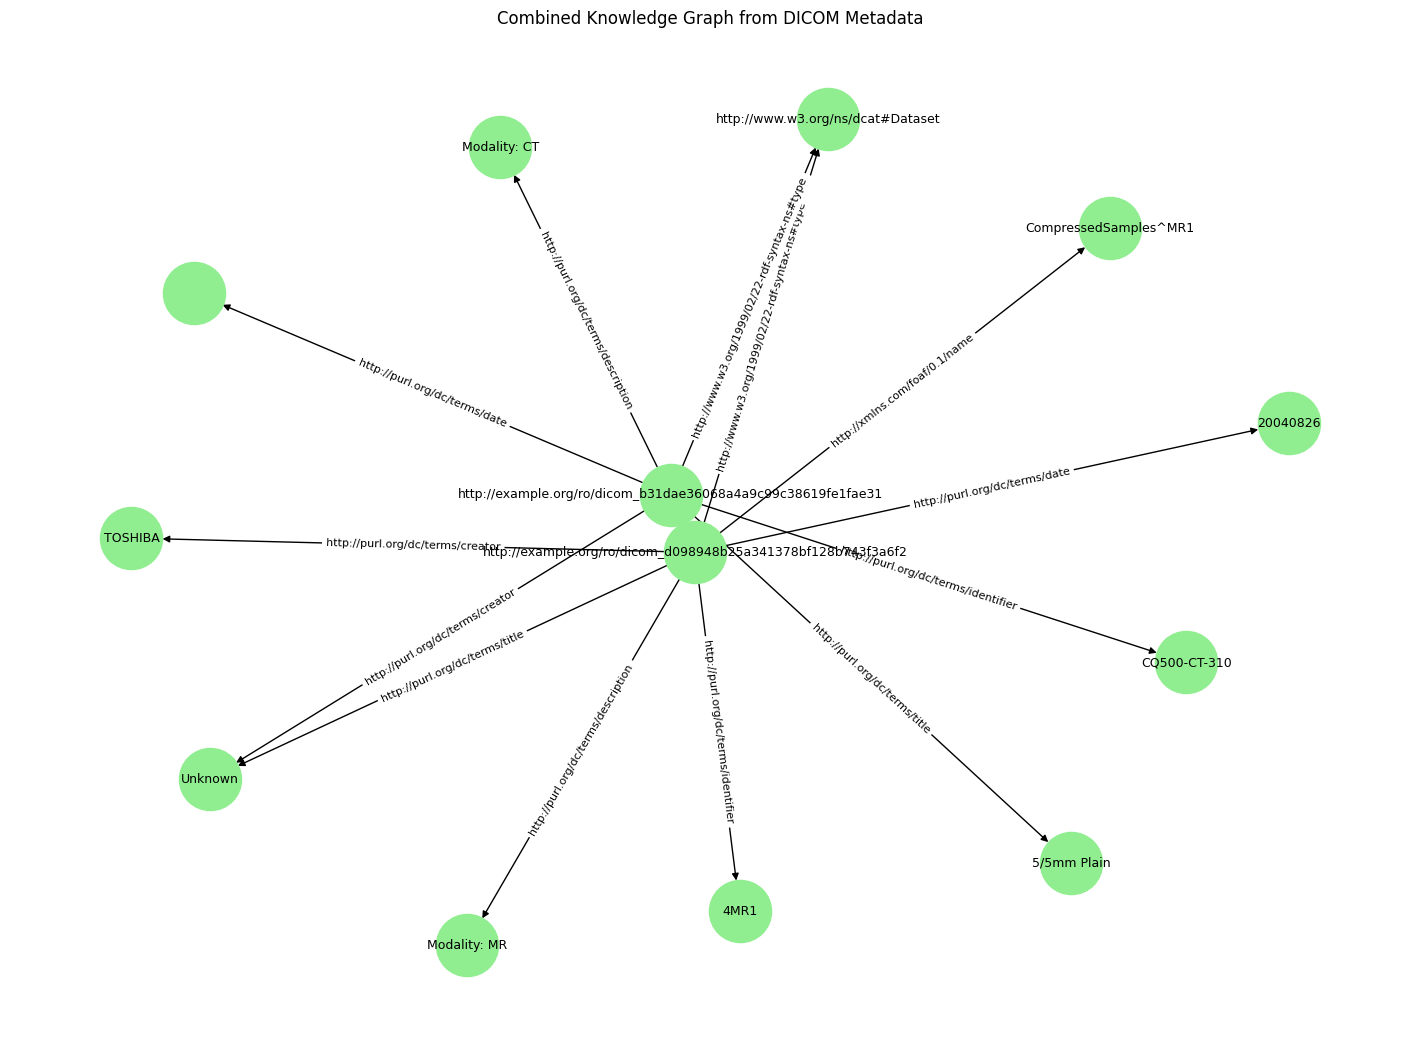

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# Convert RDF to NetworkX graph
G = nx.DiGraph()
for s, p, o in g:
    G.add_edge(str(s), str(o), label=str(p))

# Draw
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.6)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="lightgreen", font_size=9)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Combined Knowledge Graph from DICOM Metadata")
plt.show()

In [9]:
from datetime import datetime

# --- Step 1: Define the Catalog URI ---
catalog_uri = EX["dicom_catalog"]

# Add Catalog metadata
g.add((catalog_uri, RDF.type, DCAT.Catalog))
g.add((catalog_uri, DCT.title, Literal("DICOM Metadata Catalog")))
g.add((catalog_uri, DCT.description, Literal("A catalog of DICOM metadata extracted from medical imaging files.")))
g.add((catalog_uri, DCT.issued, Literal(datetime.now().date())))
g.add((catalog_uri, DCT.creator, Literal("Your Lab / Hospital / Org")))

# --- Step 2: Link All Datasets to Catalog ---
for s, p, o in g.triples((None, RDF.type, DCAT.Dataset)):
    g.add((catalog_uri, DCAT.dataset, s))

In [10]:
print(g.serialize(format="turtle"))

@prefix dcat: <http://www.w3.org/ns/dcat#> .
@prefix dct: <http://purl.org/dc/terms/> .
@prefix ex: <http://example.org/ro/> .
@prefix foaf: <http://xmlns.com/foaf/0.1/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

ex:dicom_catalog a dcat:Catalog ;
    dct:creator "Your Lab / Hospital / Org" ;
    dct:description "A catalog of DICOM metadata extracted from medical imaging files." ;
    dct:issued "2025-08-07"^^xsd:date ;
    dct:title "DICOM Metadata Catalog" ;
    dcat:dataset ex:dicom_b31dae36068a4a9c99c38619fe1fae31,
        ex:dicom_d098948b25a341378bf128b743f3a6f2 .

ex:dicom_b31dae36068a4a9c99c38619fe1fae31 a dcat:Dataset ;
    dct:creator "Unknown" ;
    dct:date "" ;
    dct:description "Modality: CT" ;
    dct:identifier "CQ500-CT-310" ;
    dct:title "5/5mm Plain" ;
    foaf:name "CQ500-CT-310" .

ex:dicom_d098948b25a341378bf128b743f3a6f2 a dcat:Dataset ;
    dct:creator "TOSHIBA" ;
    dct:date "20040826" ;
    dct:description "Modality: MR" ;
    dct:identifier "4M

In [11]:
print(g.serialize(format="json-ld", indent=2))

[
  {
    "@id": "http://example.org/ro/dicom_catalog",
    "@type": [
      "http://www.w3.org/ns/dcat#Catalog"
    ],
    "http://purl.org/dc/terms/creator": [
      {
        "@value": "Your Lab / Hospital / Org"
      }
    ],
    "http://purl.org/dc/terms/description": [
      {
        "@value": "A catalog of DICOM metadata extracted from medical imaging files."
      }
    ],
    "http://purl.org/dc/terms/issued": [
      {
        "@type": "http://www.w3.org/2001/XMLSchema#date",
        "@value": "2025-08-07"
      }
    ],
    "http://purl.org/dc/terms/title": [
      {
        "@value": "DICOM Metadata Catalog"
      }
    ],
    "http://www.w3.org/ns/dcat#dataset": [
      {
        "@id": "http://example.org/ro/dicom_b31dae36068a4a9c99c38619fe1fae31"
      },
      {
        "@id": "http://example.org/ro/dicom_d098948b25a341378bf128b743f3a6f2"
      }
    ]
  },
  {
    "@id": "http://example.org/ro/dicom_b31dae36068a4a9c99c38619fe1fae31",
    "@type": [
      "http://www.

In [12]:
import pandas as pd

datasets = []

for dataset_uri in g.subjects(RDF.type, DCAT.Dataset):
    entry = {
        "URI": str(dataset_uri),
        "Title": str(g.value(dataset_uri, DCT.title, default="")),
        "Date": str(g.value(dataset_uri, DCT.date, default="")),
        "Patient ID": str(g.value(dataset_uri, DCT.identifier, default="")),
        "Institution": str(g.value(dataset_uri, DCT.creator, default="")),
        "Modality": str(g.value(dataset_uri, DCT.description, default="")),
        "Patient Name": str(g.value(dataset_uri, FOAF.name, default="")),
    }
    datasets.append(entry)

df = pd.DataFrame(datasets)
df.head()

,URI,Title,Date,Patient ID,Institution,Modality,Patient Name
0,http://example.org/ro/dicom_b31dae36068a4a9c99...,5/5mm Plain,,CQ500-CT-310,Unknown,Modality: CT,CQ500-CT-310
1,http://example.org/ro/dicom_d098948b25a341378b...,Unknown,20040826,4MR1,TOSHIBA,Modality: MR,CompressedSamples^MR1


In [13]:
from datetime import datetime

# Create timestamp in format: YYYYMMDD_HHMMSS
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Create filename with timestamp
filename = f"dcat_catalog_{timestamp}.ttl"

# Save RDF graph in Turtle format
with open(filename, "w") as f:
    f.write(g.serialize(format="turtle"))

print(f"Saved DCAT catalog to: {filename}")

Saved DCAT catalog to: dcat_catalog_20250807_134724.ttl
